In [0]:
import warnings
warnings.filterwarnings(action='once')

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from keras.datasets import cifar10

#loading data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

num_train, img_channels, img_rows, img_cols = x_train.shape
num_test = x_test.shape[0]
num_classes = len(np.unique(y_train))


# Classes
class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# multi line f-string : https://stackoverflow.com/questions/45965007/multiline-f-string-in-python
print(f"""
Train images : {num_train}
Test images : {num_test}
Total classes : {num_classes}
Input image shape : {x_train.shape[1:]}
""")

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py:5747: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  ret

170500096/170498071 [==============================] - 6s 0us/step

Train images : 50000
Test images : 10000
Total classes : 10
Input image shape : (32, 32, 3)



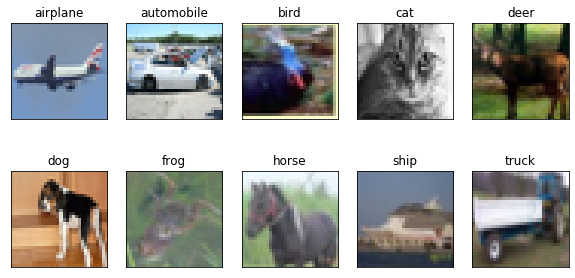

In [0]:
# checking some random images
fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
  ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
  idx = np.where(y_train[:]==i)[0] # selecting image_idx of single class
  features = x_train[idx,::]
  img_num = np.random.randint(features.shape[0])
  im = features[img_num]
  ax.set_title(class_names[i])
  plt.imshow(im)
plt.show()

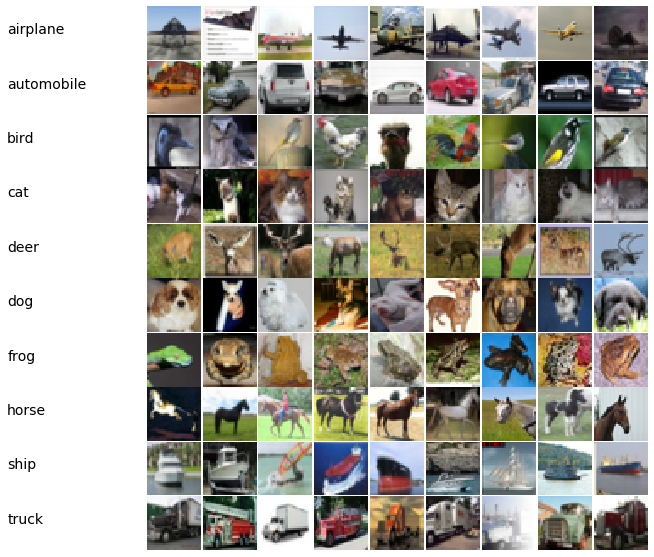

In [0]:
# display n random images for each class
n = 10
r, c = 10, n
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(y_train[:]==i)[0], c, replace=False)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, c):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(x_train[idx[j-1]], interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [0]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True


# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2



# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 6 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# print([ lr_schedule(e) for e in range(50)])


def plot_model_history(model_history):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # summarize history for accuracy
  ax[0].plot(range(1, len(model_history.history['acc'])+1), model_history.history['acc'])#, label='Training Acc')
  ax[0].plot(range(1, len(model_history.history['val_acc'])+1), model_history.history['val_acc'])#, label='Validation Acc')
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xticks(np.arange(1, len(model_history.history['acc'])+1), len(model_history.history['acc'])/10)
  ax[0].legend(['Train', 'Validation'], loc='best')

  # summarize history for loss
  ax[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
  ax[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
  ax[1].legend(['Train', 'Validation'], loc='best')

  plt.show()

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)














Learning rate:  0.001


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model_info = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=50, verbose=1, workers=4,
                        callbacks=callbacks)


Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
Learning rate:  0.001
1563/1563 [==============================] - 64s 41ms/step - loss: 1.7517 - acc: 0.4884 - val_loss: 1.5908 - val_acc: 0.5533

Epoch 00001: val_acc improved from -inf to 0.55330, saving model to /content/saved_models/cifar10_ResNet20v2_model.001.h5
Epoch 2/50
Learning rate:  0.001
1563/1563 [==============================] - 53s 34ms/step - loss: 1.3440 - acc: 0.6173 - val_loss: 1.3328 - val_acc: 0.6320

Epoch 00002: val_acc improved from 0.55330 to 0.63200, saving model to /content/saved_models/cifar10_ResNet20v2_model.002.h5
Epoch 3/50
Learning rate:  0.001
1563/1563 [==============================] - 53s 34ms/step - loss: 1.1690 - acc: 0.6752 - val_loss: 1.5233 - val_acc: 0.6003

Epoch 00003: val_acc did not improve from 0.63200
Epoch 4/50
Learning rate:  0.001
1563/1563 [==============================] - 53s 34ms/step - l

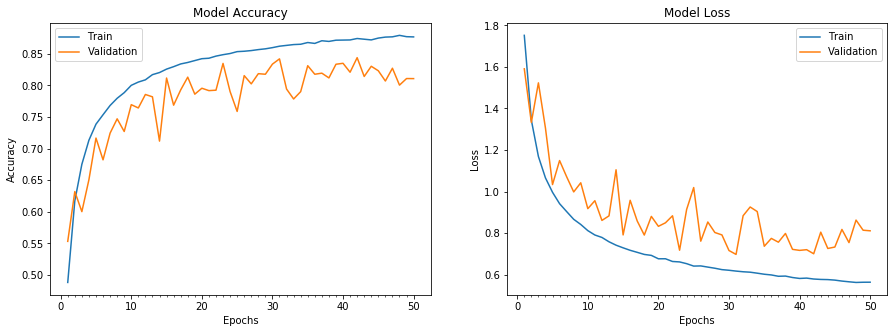

In [0]:
# plot model history
plot_model_history(model_info)

Since there is no learning rate decay model is fluctuating a lot, its seems that the model is not able to generalize better. 

In [0]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 183us/step
Test loss: 0.8117553030014039
Test accuracy: 0.8106


In [0]:
import cv2
from skimage import io

from keras.preprocessing import image
from keras.applications.resnet import resnet, preprocess_input, decode_predictions

from google.colab.patches import cv2_imshow

def GradCam(input_image, img_label, model, classes, layer_name, model_input_shape=(32, 32)):
  print(f'input url: {input_image}')
  # read image
  rim = io.imread(input_image)
  im = cv2.resize(rim, dsize=model_input_shape, interpolation=cv2.INTER_CUBIC)  # since model input is 32x32

  # prepare input as tensor
  x = image.img_to_array(im/255)
  x = np.expand_dims(x, axis=0)
  # If subtract pixel mean is enabled
  if subtract_pixel_mean:
    x -= x_train_mean
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])

  # find model output for predicted class
  class_output = model.output[:, class_idx]

  # get the last convolution layer
  last_conv_layer = model.get_layer(layer_name)

  # find the gradients corresponding to the output class (this is a tensor)
  grads = K.gradients(class_output, last_conv_layer.output)[0]

  # find the average for each channel of gradients
  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  # get iterator to parse input and compute the tensor
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  # actually compute for the given input
  pooled_grads_value, conv_layer_output_value = iterate([x])

  # multiple the pooled gradients with each channel output
  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # add all channels and divide by 64, i.e. the mean as heatmap
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  
  # apply RELU, i.e. reject all negative values and normalize by dividing by maximum
  # so that all values are between -0 and 1
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  # resize heatmap to actual image resolution i.e. 32x32 and scale from 0 to 255 with colormap
  heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  # superimpore input and output
  superimposed_img = cv2.addWeighted(im, 0.5, heatmap, 0.5, 0)

  # scale superimposed image for clarity 4 times
  superimposed_img = cv2.resize(superimposed_img, (im.shape[1]*4, im.shape[0]*4))
  sim = cv2.resize(rim, (im.shape[1]*4, im.shape[0]*4))
  
  print(f'Actual : {img_label}')
  cv2_imshow(sim)
  print('-'*81)
  print(f'Prediction : {classes[class_idx]}')
  cv2_imshow(superimposed_img)
  print('='*18)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


input url: https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg
Actual : dog


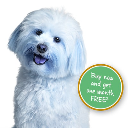

---------------------------------------------------------------------------------
Prediction : dog


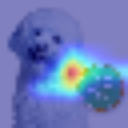

In [0]:
dog = "https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg"
GradCam(dog, 'dog', model, class_names, 'conv2d_21', model_input_shape=(32, 32))

input url: https://www.teckinfo.com/images/automobile_img.jpg
Actual : car


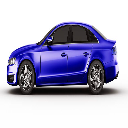

---------------------------------------------------------------------------------
Prediction : automobile


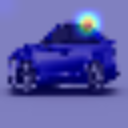

In [0]:
car = 'https://www.teckinfo.com/images/automobile_img.jpg'
GradCam(car, 'car', model, class_names, 'conv2d_21', model_input_shape=(32, 32))

In [0]:
airplanes = ['https://images.unsplash.com/photo-1543903905-cee4ab46985c', 'https://images.unsplash.com/photo-1559711469-31b420b24c10', 'https://images.unsplash.com/photo-1559023234-1e773470544f', 'https://images.unsplash.com/photo-1562368370-cff10978a647', 'https://images.unsplash.com/photo-1531642765602-5cae8bbbf285']
cars = ['https://images.unsplash.com/photo-1523676060187-f55189a71f5e', 'https://images.unsplash.com/photo-1532974297617-c0f05fe48bff', 'https://images.unsplash.com/photo-1485291571150-772bcfc10da5', 'https://images.unsplash.com/photo-1489824904134-891ab64532f1', 'https://images.unsplash.com/photo-1503376780353-7e6692767b70', 'https://images.unsplash.com/photo-1529369623266-f5264b696110']
birds = ['https://images.unsplash.com/photo-1448227922836-6d05b3f8b663', 'https://images.unsplash.com/photo-1433321768402-897b0324c   ', 'https://images.unsplash.com/photo-1507477338202-487281e6c27e', 'https://images.unsplash.com/photo-1471602671180-19fb2b491359', 'https://images.unsplash.com/photo-1506220926022-cc5c12acdb35', 'https://images.unsplash.com/photo-1511692277506-3be3a7ab1686']

input url: https://images.unsplash.com/photo-1543903905-cee4ab46985c
Actual : airplane


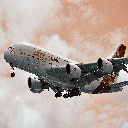

---------------------------------------------------------------------------------
Prediction : airplane


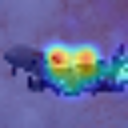

input url: https://images.unsplash.com/photo-1559711469-31b420b24c10
Actual : airplane


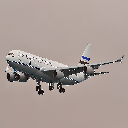

---------------------------------------------------------------------------------
Prediction : airplane


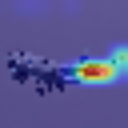

input url: https://images.unsplash.com/photo-1559023234-1e773470544f
Actual : airplane


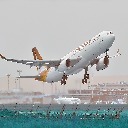

---------------------------------------------------------------------------------
Prediction : horse


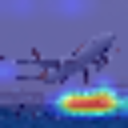

input url: https://images.unsplash.com/photo-1562368370-cff10978a647
Actual : airplane


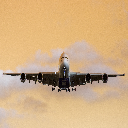

---------------------------------------------------------------------------------
Prediction : airplane


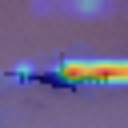

input url: https://images.unsplash.com/photo-1531642765602-5cae8bbbf285
Actual : airplane


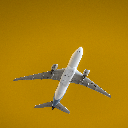

---------------------------------------------------------------------------------
Prediction : airplane


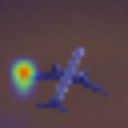

In [0]:
for url in airplanes:
  GradCam(url, 'airplane', model, class_names, 'conv2d_21', model_input_shape=(32, 32))

input url: https://images.unsplash.com/photo-1523676060187-f55189a71f5e
Actual : automobile


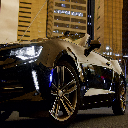

---------------------------------------------------------------------------------
Prediction : truck


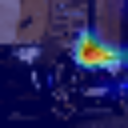

input url: https://images.unsplash.com/photo-1532974297617-c0f05fe48bff
Actual : automobile


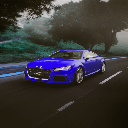

---------------------------------------------------------------------------------
Prediction : truck


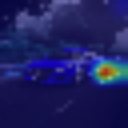

input url: https://images.unsplash.com/photo-1485291571150-772bcfc10da5
Actual : automobile


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


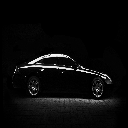

---------------------------------------------------------------------------------
Prediction : dog


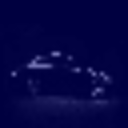

input url: https://images.unsplash.com/photo-1489824904134-891ab64532f1
Actual : automobile


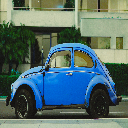

---------------------------------------------------------------------------------
Prediction : automobile


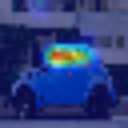

input url: https://images.unsplash.com/photo-1503376780353-7e6692767b70
Actual : automobile


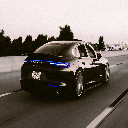

---------------------------------------------------------------------------------
Prediction : truck


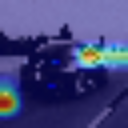

input url: https://images.unsplash.com/photo-1529369623266-f5264b696110
Actual : automobile


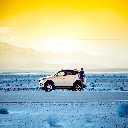

---------------------------------------------------------------------------------
Prediction : ship


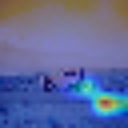

In [0]:
for url in cars:
  GradCam(url, 'automobile', model, class_names, 'conv2d_21', model_input_shape=(32, 32))

input url: https://images.unsplash.com/photo-1448227922836-6d05b3f8b663
Actual : bird


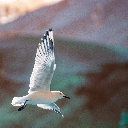

---------------------------------------------------------------------------------
Prediction : cat


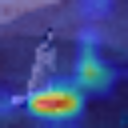

input url: https://images.unsplash.com/photo-1433321768402-897b0324c   
Actual : bird


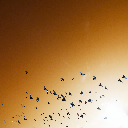

---------------------------------------------------------------------------------
Prediction : airplane


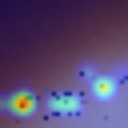

input url: https://images.unsplash.com/photo-1507477338202-487281e6c27e
Actual : bird


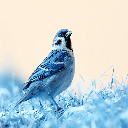

---------------------------------------------------------------------------------
Prediction : bird


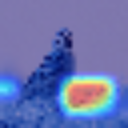

input url: https://images.unsplash.com/photo-1471602671180-19fb2b491359
Actual : bird


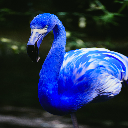

---------------------------------------------------------------------------------
Prediction : truck


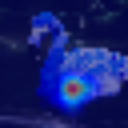

input url: https://images.unsplash.com/photo-1506220926022-cc5c12acdb35
Actual : bird


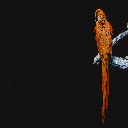

---------------------------------------------------------------------------------
Prediction : bird


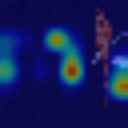

input url: https://images.unsplash.com/photo-1511692277506-3be3a7ab1686
Actual : bird


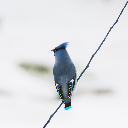

---------------------------------------------------------------------------------
Prediction : airplane


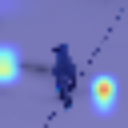

In [0]:
for url in birds:
  GradCam(url, 'bird', model, class_names, 'conv2d_21', model_input_shape=(32, 32))